In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from magicce import entropy, prior_params, find_error_probability, std_eff

# Loading expression Data

The included dataset contains log2(TPM) normalized RNA-seq data for various tissues taken from adult zebrafish at different ages. For details see [Kijima, Y. et al. Age-associated different transcriptome profiling in zebrafish and rat: insight into diversity of vertebrate aging. bioRxiv 478438 (2018)](https://www.biorxiv.org/content/10.1101/478438v1.abstract)

In [2]:
# load dataset
expression_df = pd.read_csv('./data/gene_expression.tab', sep='\t', index_col=0)
data = expression_df.values
expression_df.head()

,brain_16mo_rep1,brain_16mo_rep2,brain_16mo_rep3,brain_16mo_rep4,brain_16mo_rep5,brain_2mo_rep1,brain_2mo_rep2,brain_2mo_rep3,brain_2mo_rep4,brain_2mo_rep5,...,muscle_39mo_rep1,muscle_39mo_rep2,muscle_39mo_rep3,muscle_39mo_rep4,muscle_39mo_rep5,muscle_7mo_rep1,muscle_7mo_rep2,muscle_7mo_rep3,muscle_7mo_rep4,muscle_7mo_rep5
GeneID,,,,,,,,,,,,,,,,,,,,,
A2ML1 (1 of many),2.003886,1.699349,1.709527,1.735342,1.719059,1.711328,2.084648,1.953139,2.354774,2.309915,...,1.590810,1.572585,1.677028,2.850064,3.084047,1.930746,8.288445,2.519180,1.637498,1.650748
ABCF3,3.406648,3.367878,3.121997,3.211761,3.580235,3.681889,4.194213,3.889060,3.032369,3.864999,...,6.817735,2.713141,2.042845,3.143494,2.734619,2.525217,4.043733,2.283221,2.963904,2.199464
ACOT12,3.486173,2.841191,3.844378,3.367892,3.649668,3.295562,3.557342,3.184319,4.044197,3.149275,...,3.375806,0.831841,0.281550,0.169860,0.101192,-0.539613,0.888150,-0.490532,-0.405902,-0.173364
ACSF3,0.642943,1.564790,1.291761,1.401428,1.117463,1.140322,1.519899,1.520216,1.514848,-1.025764,...,-0.006755,1.427482,-0.485476,0.733330,-0.325173,0.818976,1.537746,0.385791,-0.031601,-0.706022
ACTC1,-1.025764,-0.290542,-1.025764,-1.025764,-1.025764,-0.808841,-1.025764,-0.902833,-1.025764,-1.025764,...,7.088967,1.757899,1.439672,3.275330,2.601047,2.733269,2.659035,4.052598,5.246153,7.691827


In [3]:
# make DataFrame for column attributes
ca = pd.DataFrame([c.split('_') for c in expression_df.columns], 
                  columns=['tissue', 'age', 'replicate'])
ca.head()

,tissue,age,replicate
0,brain,16mo,rep1
1,brain,16mo,rep2
2,brain,16mo,rep3
3,brain,16mo,rep4
4,brain,16mo,rep5


In [4]:
ca.groupby(['tissue', 'age']).count()

replicate
tissue age            
brain  16mo          5
       2mo           5
       39mo          5
       7mo           5
gill   16mo          5
       2mo           5
       39mo          5
       7mo           5
heart  16mo          5
       39mo          4
       7mo           5
liver  16mo          5
       2mo           5
       39mo          5
       7mo           5
muscle 16mo          5
       2mo           5
       39mo          5
       7mo           5

# Inferring marker genes

## Marker genes between two groups of samples

Here, we simply want to find marker genes that can differentiate between samples taken from the brain at ages 2 months and 39 months. 

In [5]:
# define groups that are compared against each other
groups = [['brain', '2mo'], ['brain', '39mo']]
groups_idx = [np.flatnonzero((ca.tissue == t)&(ca.age == a)) for t, a in groups]
groups_idx

[array([5, 6, 7, 8, 9]), array([10, 11, 12, 13, 14])]

In [6]:
# relative a priori size of different groups,
# discounting potential differences in no. of replicates
nc = [1,1]

In [7]:
# calculate conditional class entropy
# the parameters k, N determine how accurately the integrals are calculated
# one can start with smaller values and see how much of a difference it makes
H_result = entropy(data, groups_idx, ncond=nc, k=6, N=1e2)

In [8]:
# when there are only two classes, we can invert the entropy function
# H=p*log(p) and infer the probability p of misclassification given gene expression a measurement
# The function find_error_probability is an analytical solution valid only for small p 
p_result = find_error_probability(H_result)

In [9]:
# create sorted list of top marker genes
df_result = pd.DataFrame({'H(c|x)':H_result, 'p_e':p_result}, index=expression_df.index)
df_result = df_result.sort_values(by='p_e')
df_result.head(20)

,H(c|x),p_e
GeneID,,
si:ch211-1f22.16,0.005939,0.000721
tmsb,0.016608,0.002355
insm1a,0.018361,0.002648
rrm2,0.020145,0.002951
hmgn2,0.021680,0.003217
BX248395.1,0.023618,0.003558
rs1a,0.027783,0.004310
fxyd6l,0.030164,0.004751
nusap1,0.039408,0.006535


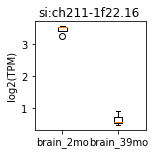

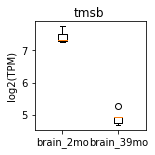

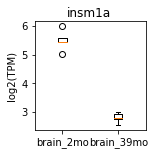

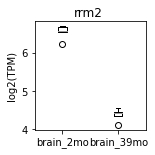

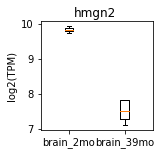

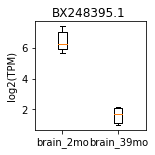

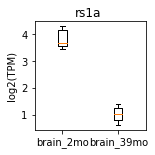

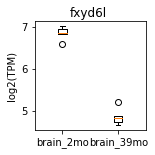

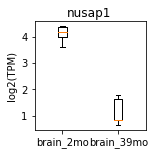

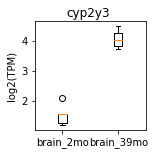

In [10]:
# check expression of top marker genes in both groups
for gene in df_result.index[:10]:
    plot_data = tuple(expression_df.loc[gene][group].values for group in groups_idx)
    plt.figure(figsize=(2,2))
    plt.boxplot(plot_data, labels=['{}_{}'.format(tissue, age) for tissue, age in groups])
    plt.suptitle(gene)
    plt.ylabel('log2(TPM)')
    

## Marker genes between more than two groups of samples

Here, we simply want to find marker genes that can differentiate between samples taken from the brain at all ages (2 months, 7 months, 16 months, and 39 months). 

In [11]:
# define groups that are compared against each other
groups = [['brain', '2mo'], ['brain', '7mo'], ['brain', '16mo'], ['brain', '39mo']]
groups_idx = [np.flatnonzero((ca.tissue == t)&(ca.age == a)) for t, a in groups]
groups_idx


[array([5, 6, 7, 8, 9]),
 array([15, 16, 17, 18, 19]),
 array([0, 1, 2, 3, 4]),
 array([10, 11, 12, 13, 14])]

In [12]:
# relative a priori size of different groups,
# discounting potential differences in no. of replicates
nc = [1,1,1,1]

In [13]:
# calculate conditional class entropy
# the parameters k, N determine how accurately the integrals are calculated
# one can start with smaller values and see how much of a difference it makes
H_result = entropy(data, groups_idx, ncond=nc, k=6, N=1e2)

In [14]:
# create sorted list of top marker genes
df_result = pd.DataFrame({'H(c|x)':H_result}, index=expression_df.index)
df_result = df_result.sort_values(by='H(c|x)')
df_result.head(20)

,H(c|x)
GeneID,
si:dkey-4p15.3,0.571329
igf2bp3,0.573582
hmgn2,0.601044
tubb5,0.604420
tmsb,0.609500
DNAJA4,0.634381
insm1a,0.639498
ppp1r14ba,0.667144
hsp90aa1.2,0.677492


In [15]:
# For each set of replicates, we want to estimate the effective standard deviation of the measurements
# For this, we need to estimate the prior distribution of variances first in each set, which have two parameters

params = [prior_params(data[group]) for group in groups_idx]
params

[(8.019918847571294, 6.397132380397177),
 (1.684415762962535, 1.4377116914864094),
 (0.9892945921489344, 1.4165754407441593),
 (0.9307141109595726, 0.14162957315915192)]

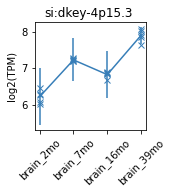

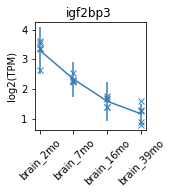

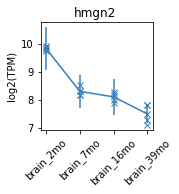

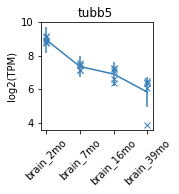

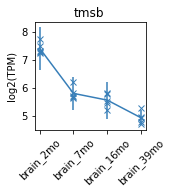

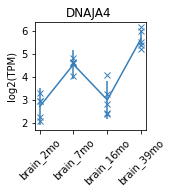

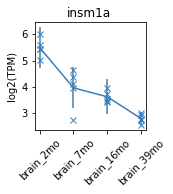

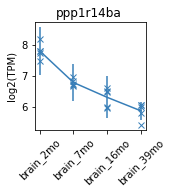

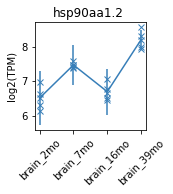

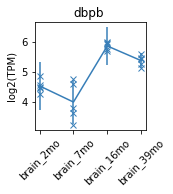

In [16]:
# For this kind of data, it is more appropriate to plot time courses
# we can estimate error bars using the std_eff function

plot_color = '#377eb8'
for gene in df_result.index[:10]:
    plot_data = tuple(expression_df.loc[gene][group].values for group in groups_idx)
    plt.figure(figsize=(2,2))
    y_mean = np.array([y.mean() for y in plot_data])
    n = len(y_mean)
    x = np.arange(n)
    plt.plot(x, y_mean, color=plot_color)
    for xi, y, (a,b) in zip(x, plot_data, params):
        y_std = std_eff(y, a, b) # estimate effective standard deviation
        plt.errorbar(xi, y=y.mean(), yerr=y_std, color=plot_color)
        plt.plot([xi]*len(y), y, 'x', color=plot_color)
    plt.xticks(ticks=x, labels=['{}_{}'.format(tissue, age) for tissue, age in groups],
              rotation=45)
    plt.suptitle(gene)
    plt.ylabel('log2(TPM)')
    